# Image classification

In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

## Make input arrays

The training images were found on the Internet, then reduced greatly in size. Here's a typical 'raw' image from the BGS:

<img src="https://resources.bgs.ac.uk/gb3d/thumbnails/BRSUG/P885148.jpg" />

Here's how the images have been processed:

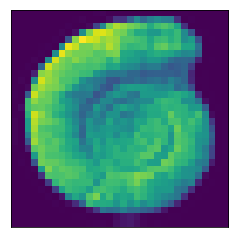

In [2]:
from io import BytesIO
import requests
from PIL import Image

r = requests.get('https://resources.bgs.ac.uk/gb3d/thumbnails/BRSUG/P885148.jpg')

img = Image.open(BytesIO(r.content))
img = img.resize((32,32), Image.ANTIALIAS).convert('L')
img = np.asarray(img)

plt.imshow(img)
plt.xticks([]); plt.yticks([])
plt.show()

Then each image is arranged into a 1D array. Let's look at the first 5 rows of the image above:

In [4]:
fig, ax = plt.subplots(figsize=(15, 0.1))
ax.matshow([img.ravel()[:160]], aspect='auto')
ax.set_xticks([]); ax.set_yticks([])
plt.show()

Lots of images have already been prepared, so we can go ahead and load the data directly:

In [ ]:
X_ = requests.get("https://s3.amazonaws.com/agilegeo/geocomp/X.npy")
y_ = requests.get("https://s3.amazonaws.com/agilegeo/geocomp/y.npy")

X = np.load(BytesIO(X_.content))
y = np.load(BytesIO(y_.content))

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y)

In [ ]:
X_train.shape, y_train.shape

In [ ]:
X_val.shape, y_val.shape

In [ ]:
classes = np.unique(y_train)
classes

### Look at one of the images

In [ ]:
X_train[0].shape

In [ ]:
plt.imshow(X_train[0].reshape(32, 32))

## MLP

In [ ]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes=(64, 64), max_iter=400)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)

In [ ]:
from sklearn.metrics import f1_score

f1_score(y_val, y_pred, average='weighted')

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_val, y_pred, labels=classes)

In [ ]:
classes

## Extra trees

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

clf = ExtraTreesClassifier(n_estimators=100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)

In [ ]:
f1_score(y_val, y_pred, average='weighted')

In [ ]:
confusion_matrix(y_val, y_pred, labels=classes)

## Prediction probabilities

Often we find that the mistakes are among the less certain choices. Let's have a look.

First, let's see the mean probability of true positives vs false positives.

In [ ]:
y_prob = clf.predict_proba(X_val)

In [ ]:
# True positives
np.mean(np.max(y_prob[y_val==y_pred], axis=1))

In [ ]:
# False positives
np.mean(np.max(y_prob[y_val!=y_pred], axis=1))

Indeed, it seems more sure about the positives. 

Let's visualize some of these. We'll use green for a good prediction, red for a wrong one. If the probability was less than 0.5 (say), we'll mute the colour.

In [ ]:
import random

def visualize(X_val, y_val, y_prob, cutoff=0.5, ncols=6, nrows=1):
    """
    Visualize some random samples from the prediction results.
    Colours: green for a good prediction, red for a wrong one. If the
    probability was less than some cutoff (default 0.5), we'll mute the colour.

    Args:
        X_val (ndarray): The validation features, n_samples x n_features.
        y_val (ndarray): The validation labels, n_samples x 1.
        y_prob (ndarray): The predicted probabilities, n_samples x n_classes.
        cutoff (float): the cutoff for 'uncertain'.
        ncols (int): how many plots across the grid.
        nrows (int): how many plots down the grid.
    """
    w, h = 2 * ncols, 2 * nrows + nrows / 2
    fig, axs = plt.subplots(figsize=(w, h), ncols=ncols, nrows=nrows)

    idx = random.sample(range(X_val.shape[0]), ncols*nrows)  # Non-repeating.
    sample = X_val[idx]

    classes = np.unique(y_val)
    shp = int(np.sqrt(X_val.shape[1]))

    for i, (img, actual, probs) in enumerate(zip(sample, y_val[idx], y_prob[idx])):
        ax = axs[i // ncols, i % ncols]
        pred = classes[np.argmax(probs)]
        prob = np.max(probs)

        img = img.reshape((shp,shp))
        ax.imshow(img, cmap='gray')
        ax.set_title(f"{pred} - {prob}\n[{actual}]")
        ax.set_xticks([])
        ax.set_yticks([])

        if prob > cutoff:
            c = 'limegreen' if (actual == pred) else 'red'
        else:
            c = 'y' if (actual == pred) else 'lightsalmon'

        for spine in ax.spines.values():
            spine.set_edgecolor(c)
            spine.set_linewidth(4)

    return axs

In [ ]:
visualize(X_val, y_val, y_prob, cutoff=0.5, ncols=8, nrows=3)
plt.show()

<html><hr />

<div>
<img src="https://avatars1.githubusercontent.com/u/1692321?s=50"><p style="text-align:center">© Agile Geoscience 2019</p>
</div></html>